# Preprocessing and Embeddings

## Dependencies

In [1]:
!pip install datasets
!pip install kaggle
!pip install kagglehub
!pip install textstat
!pip install seaborn
!pip install matplotlib
!pip install nltk
!pip install sklearn
!pip install transformers
!pip install torch
!pip install torchvision

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SK

## Load the datasets

In [2]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets") + "/News _dataset"

print("Path to dataset files:", path)

fake_ds = pd.read_csv(path + "/Fake.csv")
true_ds = pd.read_csv(path + "/True.csv")

/home/ajtaboada/nlp/project/factos_api/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/ajtaboada/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1/News _dataset


In [3]:
true_ds.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_ds.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
# Merge the datasets and add a label column

fake_ds['label'] = 0
fake_ds.head()
true_ds['label'] = 1
true_ds.head()

dataset = pd.concat([fake_ds, true_ds])
dataset.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


## Check the quality of the text

In [6]:
import textstat

# Calculate the readability of the text
dataset['gunning_fog']=dataset['text'].apply(lambda x: textstat.gunning_fog(x))
dataset['flesch_reading_ease']=dataset['text'].apply(lambda x: textstat.flesch_reading_ease(x))

dataset['title_gunning_fog']=dataset['title'].apply(lambda x: textstat.gunning_fog(x))
dataset['title_flesch_reading_ease']=dataset['title'].apply(lambda x: textstat.flesch_reading_ease(x))


dataset.head()


,title,text,subject,date,label,gunning_fog,flesch_reading_ease,title_gunning_fog,title_flesch_reading_ease
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,9.24,62.68,11.47,59.30
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,11.22,45.86,13.20,4.14
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,9.55,63.59,11.33,64.71
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,10.21,53.61,8.46,57.27
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,11.64,58.62,4.40,77.23


## Sentiment Analysis

In [7]:
# Load the VADER lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate the sentiment score for each text
dataset['compound_sentiment_score'] = dataset['text'].apply(lambda x: sia.polarity_scores(x)['compound'])
dataset['sentiment_score'] = dataset['text'].apply(lambda x: sia.polarity_scores(x)['pos'] - sia.polarity_scores(x)['neg'])
dataset['neutral_score'] = dataset['text'].apply(lambda x: sia.polarity_scores(x)['neu'])
dataset['negative_score'] = dataset['text'].apply(lambda x: sia.polarity_scores(x)['neg'])
dataset['positive_score'] = dataset['text'].apply(lambda x: sia.polarity_scores(x)['pos'])

dataset['title_compound_sentiment_score'] = dataset['title'].apply(lambda x: sia.polarity_scores(x)['compound'])
dataset['title_sentiment_score'] = dataset['title'].apply(lambda x: sia.polarity_scores(x)['pos'] - sia.polarity_scores(x)['neg'])
dataset['title_neutral_score'] = dataset['title'].apply(lambda x: sia.polarity_scores(x)['neu'])
dataset['title_negative_score'] = dataset['title'].apply(lambda x: sia.polarity_scores(x)['neg'])
dataset['title_positive_score'] = dataset['title'].apply(lambda x: sia.polarity_scores(x)['pos'])

dataset.head()

# Calculate the average sentiment score
dataset['compound_sentiment_score'].mean()

np.float64(-0.014156098267183394)

Average sentiment scores by news type (0=Fake, 1=Real):
       compound_sentiment_score  sentiment_score  neutral_score  \
label                                                             
0                     -0.083809        -0.003797       0.787757   
1                      0.062209         0.004478       0.841031   

       negative_score  positive_score  
label                                  
0            0.094605        0.090807  
1            0.077222        0.081700  


<Figure size 1000x600 with 0 Axes>

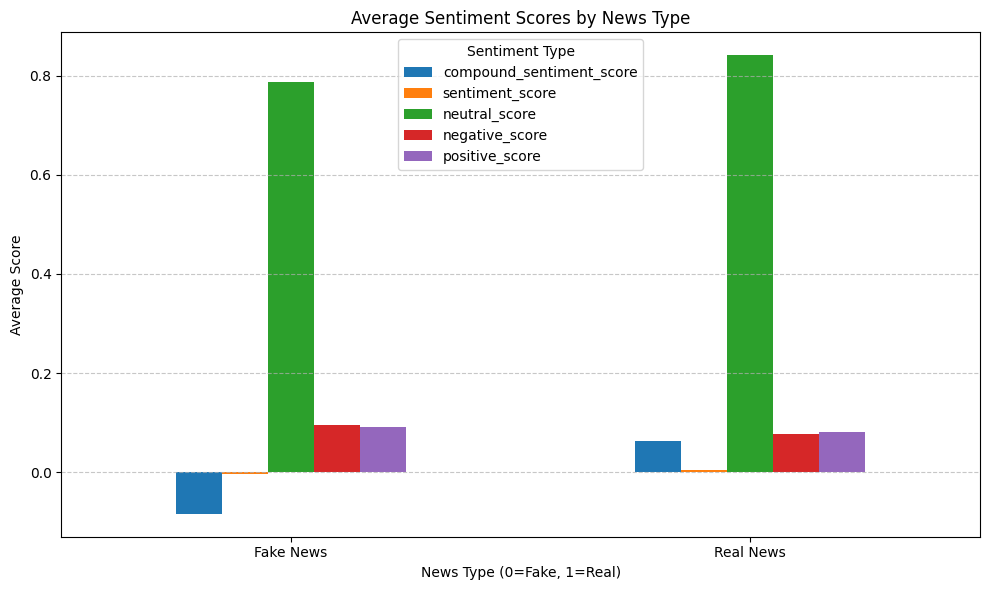

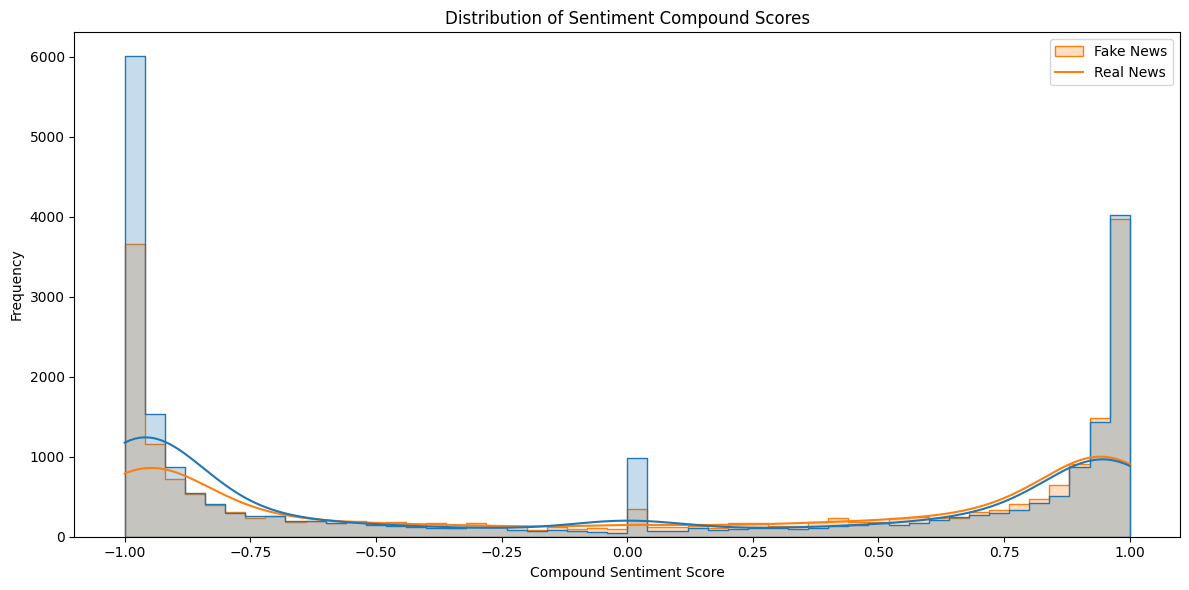

In [8]:
dataset['sentiment_score'].head()

sentiment_by_label = dataset.groupby('label')[
    ['compound_sentiment_score', 'sentiment_score', 'neutral_score', 'negative_score', 'positive_score']
].mean()

print("Average sentiment scores by news type (0=Fake, 1=Real):")
print(sentiment_by_label)

# Visualize the sentiment differences
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sentiment_by_label.plot(kind='bar', figsize=(10, 6))
plt.title('Average Sentiment Scores by News Type')
plt.xlabel('News Type (0=Fake, 1=Real)')
plt.ylabel('Average Score')
plt.xticks([0, 1], ['Fake News', 'Real News'], rotation=0)
plt.legend(title='Sentiment Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot distribution of compound sentiment scores
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='compound_sentiment_score', hue='label', 
             bins=50, kde=True, element='step', common_norm=False)
plt.title('Distribution of Sentiment Compound Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.legend(labels=['Fake News', 'Real News'])
plt.tight_layout()
plt.show()

## Data Preprocessing: Removing stopwords, tokenization, lemmatization

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ajtaboada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Drop rows with missing values

dataset = dataset.dropna()
dataset.head()

,title,text,subject,date,label,gunning_fog,flesch_reading_ease,title_gunning_fog,title_flesch_reading_ease,compound_sentiment_score,sentiment_score,neutral_score,negative_score,positive_score,title_compound_sentiment_score,title_sentiment_score,title_neutral_score,title_negative_score,title_positive_score
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,9.24,62.68,11.47,59.30,-0.8681,0.010,0.705,0.143,0.153,-0.7096,-0.371,0.629,0.371,0.000
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,11.22,45.86,13.20,4.14,-0.7141,-0.012,0.834,0.089,0.077,-0.3400,-0.255,0.745,0.255,0.000
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,9.55,63.59,11.33,64.71,-0.9958,-0.093,0.792,0.150,0.057,-0.2960,-0.065,0.699,0.183,0.118
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,10.21,53.61,8.46,57.27,-0.9243,-0.033,0.878,0.078,0.045,-0.2484,-0.133,0.867,0.133,0.000
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,11.64,58.62,4.40,77.23,0.5396,0.004,0.848,0.074,0.078,0.0000,0.000,1.000,0.000,0.000


In [11]:
# First tokenize
dataset['text_tokens'] = dataset['text'].apply(word_tokenize)
dataset['title_tokens'] = dataset['title'].apply(word_tokenize)

# Remove stopwords (on the tokens)
stop_words = set(stopwords.words('english'))
dataset['text_tokens'] = dataset['text_tokens'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])
dataset['title_tokens'] = dataset['title_tokens'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])

# Remove non-alphabetic tokens
dataset['text_tokens'] = dataset['text_tokens'].apply(lambda tokens: [word for word in tokens if word.isalpha()])
dataset['title_tokens'] = dataset['title_tokens'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

# Lemmatize tokens
lemmatizer = WordNetLemmatizer()
dataset['text_tokens'] = dataset['text_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
dataset['title_tokens'] = dataset['title_tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

# For display or further text-based processing, join back to strings
dataset['text_clean'] = dataset['text_tokens'].apply(lambda tokens: ' '.join(tokens))
dataset['title_clean'] = dataset['title_tokens'].apply(lambda tokens: ' '.join(tokens))

In [12]:
dataset.head()


,title,text,subject,date,label,gunning_fog,flesch_reading_ease,title_gunning_fog,title_flesch_reading_ease,compound_sentiment_score,...,positive_score,title_compound_sentiment_score,title_sentiment_score,title_neutral_score,title_negative_score,title_positive_score,text_tokens,title_tokens,text_clean,title_clean
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,9.24,62.68,11.47,59.30,-0.8681,...,0.153,-0.7096,-0.371,0.629,0.371,0.000,"[donald, trump, wish, american, happy, new, ye...","[donald, trump, sends, embarrassing, new, year...",donald trump wish american happy new year leav...,donald trump sends embarrassing new year eve m...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,11.22,45.86,13.20,4.14,-0.7141,...,0.077,-0.3400,-0.255,0.745,0.255,0.000,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus...",house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,9.55,63.59,11.33,64.71,-0.9958,...,0.057,-0.2960,-0.065,0.699,0.183,0.118,"[friday, revealed, former, milwaukee, sheriff,...","[sheriff, david, clarke, becomes, internet, jo...",friday revealed former milwaukee sheriff david...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,10.21,53.61,8.46,57.27,-0.9243,...,0.045,-0.2484,-0.133,0.867,0.133,0.000,"[christmas, day, donald, trump, announced, wou...","[trump, obsessed, even, obama, name, coded, we...",christmas day donald trump announced would bac...,trump obsessed even obama name coded website i...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,11.64,58.62,4.40,77.23,0.5396,...,0.078,0.0000,0.000,1.000,0.000,0.000,"[pope, francis, used, annual, christmas, day, ...","[pope, francis, called, donald, trump, christm...",pope francis used annual christmas day message...,pope francis called donald trump christmas speech


In [13]:
!pip install scikit-learn

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

# Use only numerical features first
features = dataset[['gunning_fog', 'flesch_reading_ease', 
                   'compound_sentiment_score', 'sentiment_score',
                   'neutral_score', 'negative_score', 'positive_score',
                   'title_gunning_fog', 'title_flesch_reading_ease',
                   'title_compound_sentiment_score', 'title_sentiment_score']]

X_train, X_test, y_train, y_test = train_test_split(
    features, dataset['label'], test_size=0.2, random_state=42)

# Try logistic regression first
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      4733
           1       0.70      0.69      0.70      4247

    accuracy                           0.71      8980
   macro avg       0.71      0.71      0.71      8980
weighted avg       0.71      0.71      0.71      8980



/home/ajtaboada/nlp/project/factos_api/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Convert tokens back to strings for vectorization
dataset['text_str'] = dataset['text_tokens'].apply(lambda x: ' '.join(x))

# Create a pipeline with TF-IDF and classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', RandomForestClassifier())
])

X_train, X_test, y_train, y_test = train_test_split(
    dataset['text_str'], dataset['label'], test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4733
           1       1.00      1.00      1.00      4247

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [16]:
from sklearn.model_selection import cross_val_score

# Define your pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', RandomForestClassifier())
])

# Perform 5-fold cross-validation
cv_scores = cross_val_score(pipeline, dataset['text_str'], dataset['label'], cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Cross-validation scores: [0.9981069  0.99710468 0.99376392 0.99331774 0.99264952]
Mean CV score: 0.9950 (±0.0022)


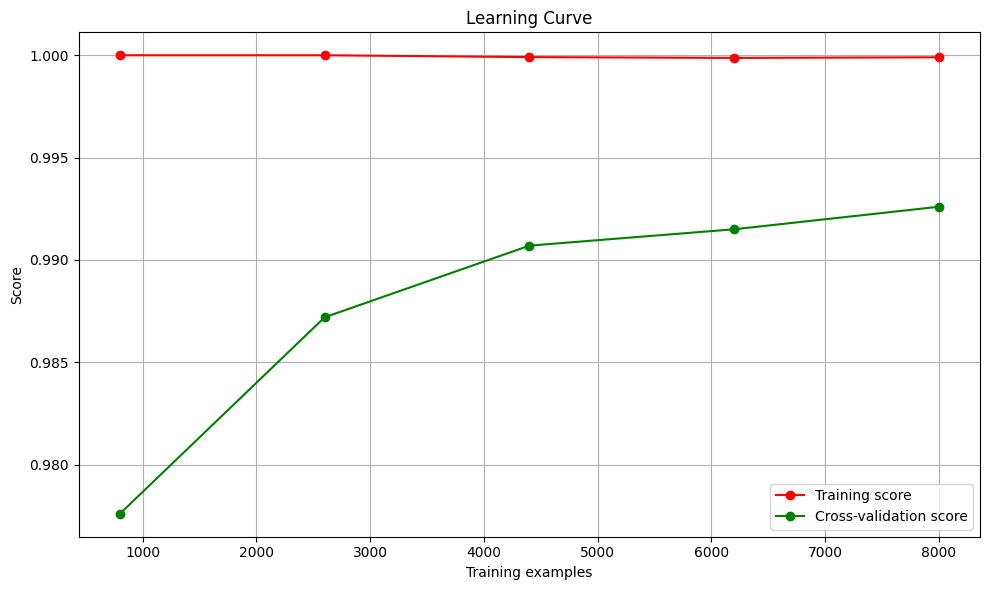

In [17]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5))
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# Use a smaller subset for computational efficiency
sample_size = min(10000, len(dataset))
sampled_indices = np.random.choice(len(dataset), sample_size, replace=False)
sampled_texts = dataset['text_str'].iloc[sampled_indices]
sampled_labels = dataset['label'].iloc[sampled_indices]

plot_learning_curve(pipeline, sampled_texts, sampled_labels)

In [18]:
from sklearn.naive_bayes import MultinomialNB

simpler_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),
    ('clf', MultinomialNB())
])

X_train, X_test, y_train, y_test = train_test_split(
    dataset['text_str'], dataset['label'], test_size=0.2, random_state=42)

simpler_pipeline.fit(X_train, y_train)
y_pred = simpler_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4733
           1       0.91      0.91      0.91      4247

    accuracy                           0.92      8980
   macro avg       0.92      0.91      0.91      8980
weighted avg       0.92      0.92      0.92      8980



In [19]:
import pickle
import os

# Create a models directory if it doesn't exist
os.makedirs("../api/models", exist_ok=True)

# Save the logistic regression model
with open("../api/models/logistic_regression.pkl", "wb") as f:
    pickle.dump(model, f)  # The logistic regression model

# Save the random forest model
with open("../api/models/random_forest.pkl", "wb") as f:
    pickle.dump(pipeline, f)  # The random forest pipeline

# Save the naive bayes model
with open("../api/models/naive_bayes.pkl", "wb") as f:
    pickle.dump(simpler_pipeline, f)  # The naive bayes pipeline

print("All models saved successfully!")

All models saved successfully!
